### Load needed libraries

In [ ]:
import os
import numpy as np
import anndata
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
from joblib import Parallel, delayed
from joblib import parallel_backend
import glob
%matplotlib inline
import csv
import scanpy as sc
import copy
import random
import scvi
import scipy as sp
import warnings
from datetime import datetime
from igraph import *
from pylab import *

sc.settings.n_jobs = 32
warnings.filterwarnings("ignore")
plt.ioff()

pwd = os.getcwd()

In [2]:
def prepare_anndata(adata, region, split_key, split_value, date_tag, metadata_to_color):
    if os.path.exists(os.path.join(pwd, "output", region, split_value.replace("/", " ") + "_CZI_display." + date_tag + ".h5ad")):
        print(str(datetime.datetime.now()) + " -- Skipping " + split_value + " because an output AnnData exists")
        return
        
    print(str(datetime.datetime.now()) + " -- Starting export of " + split_value)
    primary_data = True
    if split_value != "Whole Taxonomy":
        markers = pd.read_csv(os.path.join(pwd, "input", region, "models", split_value.replace("/", " "), "scVI_model", "var_names.csv"), header=None)
        markers = markers[0].to_list()
        model = scvi.model.SCVI.load(os.path.join(pwd, "input", region, "models", split_value.replace("/", " "), "scVI_model"), adata[:, markers])
        with parallel_backend('threading', n_jobs=32):
            adata.obsm["X_scVI"] = model.get_latent_representation()
            sc.pp.neighbors(adata, use_rep="X_scVI")
            sc.tl.umap(adata)
        primary_data = False

    # Add uns elements required by the schema
    adata.uns["schema_version"] = "3.0.0"
    adata.uns["title"] = split_value + " - " + region + ": Seattle Alzheimer's Disease Atlas (SEA-AD)"
    #adata.uns["X_normalization"] = "ln(UP10K+1)"
    adata.uns["batch_condition"] = ["Specimen ID"]
    adata.uns["default_embedding"] = "X_umap"
    del adata.uns["_scvi"]
    del adata.uns["subclass_scANVI_colors"]
    del adata.uns["supertype_scANVI_leiden_colors"]
    
    # Remove unwanted obsm values
    del adata.obsm["_scvi_extra_categoricals"]
    del adata.obsm["_scvi_extra_continuous"]
    
    # Convert var_names to ensembl IDs
    ensembl_ids = pd.read_csv(os.path.join(pwd, "input", "genes.gtf"), sep="\t", header=None, skiprows=5)
    re_name = re.compile('gene_name "([^"]+)')
    re_id = re.compile('gene_id "([^"]+)')
    gene_names = [re_name.search(ensembl_ids.iloc[i, 8])[1] for i in range(ensembl_ids.shape[0])]
    gene_ids = [re_id.search(ensembl_ids.iloc[i, 8])[1] for i in range(ensembl_ids.shape[0])]
    names_to_ids = pd.DataFrame(
        {
            "gene_ids": gene_ids,
            "gene_names": gene_names
        }
    )
    names_to_ids = names_to_ids.drop_duplicates()
    names_to_ids.index = names_to_ids["gene_ids"]
    
    # Compare ensemblIDs from 10x (Gencode v32) to CZI (Gencode v38) and recover 15 IDs with the same name
    gencode_ids = pd.read_csv(os.path.join(pwd, "input", "gencode.v38.primary_assembly.annotation.gtf"), sep="\t", header=None, skiprows=5)
    re_name = re.compile('gene_name "([^"]+)')
    re_id = re.compile('gene_id "([^"]+)')
    gencode_names = [re_name.search(gencode_ids.iloc[i, 8])[1] for i in range(gencode_ids.shape[0])]
    gencode_ids = [re_id.search(gencode_ids.iloc[i, 8])[1] for i in range(gencode_ids.shape[0])]
    gencode_names_to_ids = pd.DataFrame(
        {
            "gene_ids": gencode_ids,
            "gene_names": gencode_names
        }
    )
    gencode_names_to_ids = gencode_names_to_ids.drop_duplicates()
    gencode_names_to_ids["gene_ids"] = [i.split(".")[0] for i in gencode_names_to_ids["gene_ids"]]
    gencode_names_to_ids.index = gencode_names_to_ids["gene_names"]
    tossed_genes = names_to_ids.loc[np.setdiff1d(names_to_ids["gene_ids"], gencode_names_to_ids["gene_ids"]), "gene_names"]
    names_to_ids.index = names_to_ids["gene_names"].copy()
    names_to_ids.loc[np.intersect1d(tossed_genes, gencode_names_to_ids.index), :] = gencode_names_to_ids.loc[np.intersect1d(tossed_genes, gencode_names_to_ids.index), :]
    
    # Recover IDs where gene to ID mapping was not 1-to-1
    names_to_ids = names_to_ids.loc[~(names_to_ids["gene_names"].duplicated(keep="first")), :]
    no_match_gene = np.setdiff1d(adata.var_names, names_to_ids.gene_names)
    tmp = pd.DataFrame(
        {
            "gene_ids": [i.split(" ")[1] for i in no_match_gene],
            "gene_names": no_match_gene
        }
    )
    names_to_ids = pd.concat([names_to_ids, tmp], axis=0)
    names_to_ids.index = names_to_ids["gene_names"].copy()
    adata.var_names = pd.Index(names_to_ids.loc[adata.var_names, "gene_ids"])
    
    # Add var elements required by the schema
    #adata.var["feature_biotype"] = "gene"
    adata.var.drop(["gene_ids"], axis=1, inplace=True)
    
    # add obs elements required by the schema
    adata.obs_names = adata.obs["exp_component_name"].copy()
    
    adata.obs["donor_id"] = adata.obs["donor_name"].copy()
    
    adata.obs["assay_ontology_term_id"] = adata.obs["method"].copy()
    metadata_to_ids = {
        "10Xv3": "EFO:0009922",
        "10Xv3.1": "EFO:0009922",
        "10xMulti": "EFO:0030059"   # Old: EFO:0008995
    }
    adata.obs["assay_ontology_term_id"] = adata.obs["assay_ontology_term_id"].map(metadata_to_ids).astype('category')
    
    adata.obs["suspension_type"] = "nucleus"
    
    adata.obs["cell_type_ontology_term_id"] = adata.obs["subclass_scANVI"].copy()
    metadata_to_ids = {
        "L2/3 IT": "CL:4023040",
        "L4 IT": "CL:4023040",
        "L5 IT": "CL:4023040",
        "L6 IT": "CL:4023040",
        "L6 IT Car3": "CL:4023040",
        "L6b": "CL:4023038",
        "L5 ET": "CL:4023041",
        "L5/6 NP": "CL:4023012",
        "L6 CT": "CL:4023013",
        "Lamp5": "CL:4023011",
        "Lamp5 Lhx6": "CL:4023011",# **
        "Sncg": "CL:4023015",
        "Vip": "CL:4023016",
        "Pax6": "CL:4023070",
        "Sst": "CL:4023017",
        "Sst Chodl": "CL:4023017",
        "Pvalb": "CL:4023018",
        "Chandelier": "CL:4023036",
        "Astrocyte": "CL:0002605",# **
        "Endothelial": "CL:1001602", # **
        "Microglia-PVM": "CL:0000129", # **
        "OPC": "CL:0002453",
        "Oligodendrocyte": "CL:0000128", # **
        "VLMC": "CL:4023051"
    }
    adata.obs["cell_type_ontology_term_id"] = adata.obs["cell_type_ontology_term_id"].map(metadata_to_ids).astype('category')
    
    adata.obs["development_stage_ontology_term_id"] = [str(i) for i in adata.obs["age_at_death"]]
    metadata_to_ids = {
        "29.0": "HsapDv:0000123",
        "42.0": "HsapDv:0000136",
        "50.0": "HsapDv:0000144",
        "68.0": "HsapDv:0000162",
        "69.0": "HsapDv:0000163",
        "70.0": "HsapDv:0000164",
        "72.0": "HsapDv:0000166",
        "75.0": "HsapDv:0000169",
        "77.0": "HsapDv:0000171",
        "78.0": "HsapDv:0000172",
        "80.0": "HsapDv:0000206",
        "81.0": "HsapDv:0000207",
        "82.0": "HsapDv:0000208",
        "83.0": "HsapDv:0000209",
        "84.0": "HsapDv:0000210",
        "85.0": "HsapDv:0000211",
        "86.0": "HsapDv:0000212",
        "87.0": "HsapDv:0000213",
        "88.0": "HsapDv:0000214",
        "89.0": "HsapDv:0000215",
        "90.0": "HsapDv:0000095",
        "91.0": "HsapDv:0000095",
        "92.0": "HsapDv:0000095",
        "93.0": "HsapDv:0000095",
        "94.0": "HsapDv:0000095",
        "95.0": "HsapDv:0000095",
        "96.0": "HsapDv:0000095",
        "97.0": "HsapDv:0000095",
        "98.0": "HsapDv:0000095",
        "99.0": "HsapDv:0000095",
        "100.0": "HsapDv:0000095",
        "102.0": "HsapDv:0000095"
    }
    adata.obs["development_stage_ontology_term_id"] = adata.obs["development_stage_ontology_term_id"].map(metadata_to_ids).astype('category')
    
    adata.obs["disease_ontology_term_id"] = "PATO:0000461"
    adata.obs.loc[adata.obs["ch_cognitivestatus_binary"] == "Dementia", "disease_ontology_term_id"] = "MONDO:0001627"
    adata.obs["disease_ontology_term_id"] = adata.obs["disease_ontology_term_id"].astype("category")
    
    adata.obs["self_reported_ethnicity_ontology_term_id"] = "unknown"
    adata.obs.loc[(adata.obs["ch_race___1"] == "Checked")
              & (adata.obs["self_reported_ethnicity_ontology_term_id"] == "unknown"), "self_reported_ethnicity_ontology_term_id"] = "HANCESTRO:0005"
    adata.obs.loc[(adata.obs["ch_race___2"] == "Checked")
              & (adata.obs["self_reported_ethnicity_ontology_term_id"] == "unknown"), "self_reported_ethnicity_ontology_term_id"] = "HANCESTRO:0016"
    adata.obs.loc[(adata.obs["ch_race___3"] == "Checked")
              & (adata.obs["self_reported_ethnicity_ontology_term_id"] == "unknown"), "self_reported_ethnicity_ontology_term_id"] = "HANCESTRO:0008"
    
    adata.obs.loc[(adata.obs["donor_name"] == "H200.1023"), "self_reported_ethnicity_ontology_term_id"] = "HANCESTRO:0015"
    adata.obs.loc[(adata.obs["ch_raceother"] == "Mixed"), "self_reported_ethnicity_ontology_term_id"] = "HANCESTRO:0306"
    
    # All other remaining reference donors were Caucasian
    adata.obs.loc[(adata.obs["self_reported_ethnicity_ontology_term_id"] == "unknown"), "self_reported_ethnicity_ontology_term_id"] = "HANCESTRO:0005"
    
    adata.obs["self_reported_ethnicity_ontology_term_id"] = adata.obs["self_reported_ethnicity_ontology_term_id"].astype("category")

    adata.obs["organism_ontology_term_id"] = "NCBITaxon:9606"
    adata.obs["organism_ontology_term_id"] = adata.obs["organism_ontology_term_id"].astype("category")
    
    adata.obs["sex_ontology_term_id"] = adata.obs["sex"].copy()
    adata.obs["sex_ontology_term_id"].cat.rename_categories(
        {
            "Female": "PATO:0000383",
            "Male": "PATO:0000384"
        },
        inplace=True
    )
    adata.obs.drop("sex", axis=1, inplace=True)
    
    adata.obs["tissue_ontology_term_id"] = "UBERON:0002771"
    adata.obs["tissue_ontology_term_id"] = adata.obs["tissue_ontology_term_id"].astype("category")
    
    adata.obs["is_primary_data"] = primary_data
    
    # Move UMIs to adata.raw and freeze it
    adata = adata[:, np.intersect1d(adata.var_names, gencode_names_to_ids["gene_ids"])].copy()
    tmp = adata.X.copy()
    adata.X = adata.layers["UMIs"]
    del adata.layers["UMIs"]
    adata.raw = adata
    adata.X = tmp
    del tmp
    adata.var["feature_is_filtered"] = False

    
    # Metadata tweaks for public display
    adata.obs.loc[adata.obs["uwa"] == "UWA 7186", "sex_ontology_term_id"] = "PATO:0000384"
    
    adata.obs["age_at_death_binned"] = "Less than 65 years old"
    adata.obs.loc[(adata.obs["age_at_death"] >= 65) & (adata.obs["age_at_death"] < 78), "age_at_death_binned"] = "65 to 77 years old"
    adata.obs.loc[(adata.obs["age_at_death"] >= 78) & (adata.obs["age_at_death"] < 90), "age_at_death_binned"] = "78 to 89 years old"
    adata.obs.loc[(adata.obs["age_at_death"] >= 90), "age_at_death_binned"] = "90+ years old"

    adata.obs["age_at_death_binned"] = adata.obs["age_at_death_binned"].astype("category")
    
    adata.obs["ch_cognitivestatus_binary"].cat.add_categories("Reference", inplace=True)
    adata.obs["ch_cognitivestatus_binary"].fillna("Reference", inplace=True)

    adata.obs["adneurochange"].cat.add_categories("Reference", inplace=True)
    adata.obs["adneurochange"].fillna("Reference", inplace=True)

    adata.obs["braak"].cat.add_categories("Reference", inplace=True)
    adata.obs["braak"].fillna("Reference", inplace=True)
    
    adata.obs["thal"].cat.add_categories("Reference", inplace=True)
    adata.obs["thal"].fillna("Reference", inplace=True)

    adata.obs["cscore"].cat.add_categories("Reference", inplace=True)
    adata.obs["cscore"].fillna("Reference", inplace=True)
    
    adata.obs["lewybodydisease"].cat.add_categories("Reference", inplace=True)
    adata.obs["lewybodydisease"].fillna("Reference", inplace=True)
    
    adata.obs["late_stage"].cat.add_categories("Reference", inplace=True)
    adata.obs["late_stage"].fillna("Reference", inplace=True)

    adata.obs["micro_microvascularbrain_binned"] = "Reference"
    adata.obs.loc[adata.obs["reference_cell"] == 0, "micro_microvascularbrain_binned"] = [str(i) for i in pd.cut(adata[adata.obs["reference_cell"] == 0].obs["micro_microvascularbrain"], bins=3)]
    adata.obs["micro_microvascularbrain_binned"] = adata.obs["micro_microvascularbrain_binned"].astype("category")
    adata.obs["micro_microvascularbrain_binned"].cat.rename_categories(
        {
            "(-0.01, 3.333]": "0 to 3 microinfarcts",
            "(3.333, 6.667]": "4 to 6 microinfarcts",
            "(6.667, 10.0]": "7 to 10 microinfarcts"
        },
        inplace=True
    )
    
    adata.obs["pmi_date_binned"] = "Reference"
    adata.obs.loc[adata.obs["reference_cell"] == 0, "pmi_date_binned"] = [str(i) for i in pd.cut(adata[adata.obs["reference_cell"] == 0].obs["pmi_date"], bins=3)]
    adata.obs["pmi_date_binned"] = adata.obs["pmi_date_binned"].astype("category")
    adata.obs["pmi_date_binned"].cat.rename_categories(
        {
            "(3.192, 5.939]": "3.2 to 5.9 hours",
            "(5.939, 8.678]": "5.9 to 8.7 hours",
            "(8.678, 11.417]": "8.7 to 11.4 hours"
        },
        inplace=True
    )

    adata.obs["ch_apoe_four"] = adata.obs["ch_apoestatuses"].str.contains("4")
    adata.obs["ch_apoe_four"].fillna("Reference", inplace=True)
    adata.obs["ch_apoe_four"] = adata.obs["ch_apoe_four"].astype("category")
    adata.obs["ch_apoe_four"].cat.rename_categories({True: "Y", False: "N"}, inplace=True)
    
    adata.obs["ch_education_years_binned"] = "Reference"
    adata.obs.loc[adata.obs["reference_cell"] == 0, "ch_education_years_binned"] = [str(i) for i in pd.cut(adata[adata.obs["reference_cell"] == 0].obs["ch_education_years"], bins=3)]
    adata.obs["ch_education_years_binned"] = adata.obs["ch_education_years_binned"].astype("category")
    adata.obs["ch_education_years_binned"].cat.rename_categories(
        {
            "(11.991, 15.0]": "12 to 15 years",
            "(15.0, 18.0]": "16 to 18 years",
            "(18.0, 21.0]": "19 to 21 years"
        },
        inplace=True
    )
    
    adata.obs["reference_cell"] = adata.obs["reference_cell"].astype("category")
    adata.obs["reference_cell"].cat.rename_categories(
        {
            0: "False",
            1: "True",
        },
        inplace=True
    )

    dend_order = pd.read_csv(os.path.join(pwd, "input", region, "cluster_order_and_colors.csv"))
    #adata.uns["Subclass_colors"] = dend_order["subclass_color"].drop_duplicates().to_numpy()
    #adata.uns["Supertype_colors"] = dend_order["cluster_color"].to_numpy()

    #adata.obs["class_scANVI"].cat.rename_categories(
    #    {
    #        "exc": "Neuronal: Glutamatergic",
    #        "inh": "Neuronal: GABAergic",
    #        "glia": "Non-neuronal and Non-neural"
    #    },
    #    inplace=True
    #)
    class_order = [j for j in dend_order["class_label"].drop_duplicates() if j in adata.obs["class_scANVI"].cat.categories]
    adata.obs["class_scANVI"].cat.reorder_categories(class_order, inplace=True)

    #adata.obs["subclass_scANVI"].cat.rename_categories(
    #    {
    #        "Lamp5_Lhx6": "Lamp5 Lhx6",
    #        "Astro": "Astrocyte",
    #        "Oligo": "Oligodendrocyte",
    #        "Endo": "Endothelial",
    #        "Micro-PVM": "Microglia-PVM"
    #    },
    #    inplace=True
    #)
    class_order = [j for j in dend_order["subclass_label"].drop_duplicates() if j in adata.obs["subclass_scANVI"].cat.categories]
    adata.obs["subclass_scANVI"].cat.reorder_categories(class_order, inplace=True)
    
    class_order = [j for j in dend_order["cluster_label"].drop_duplicates() if j in adata.obs["supertype_scANVI_leiden"].cat.categories]
    adata.obs["supertype_scANVI_leiden"].cat.reorder_categories(class_order, inplace=True)

    adata = adata[np.random.choice(adata.n_obs, adata.n_obs, replace=False)].copy()
    
    adata.obs["age_at_death_binned"].cat.reorder_categories(["Less than 65 years old", "65 to 77 years old", "78 to 89 years old", "90+ years old"], inplace=True)
    adata.obs["ch_cognitivestatus_binary"].cat.reorder_categories(["Reference", "No dementia", "Dementia"], inplace=True)
    adata.obs["adneurochange"].cat.reorder_categories(["Reference", "Not AD", "Low", "Intermediate", "High"], inplace=True)
    adata.obs["braak"].cat.reorder_categories(["Reference", "Braak 0", "Braak II", "Braak III", "Braak IV", "Braak V", "Braak VI"], inplace=True)
    adata.obs["thal"].cat.reorder_categories(["Reference", "Thal 0", "Thal 1", "Thal 2", "Thal 3", "Thal 4", "Thal 5"], inplace=True)
    adata.obs["cscore"].cat.reorder_categories(["Reference", 'Absent', 'Sparse', 'Moderate', 'Frequent'], inplace=True)
    adata.obs["lewybodydisease"].cat.reorder_categories(["Reference", 'Not Identified (olfactory bulb not assessed)', 'Not Identified (olfactory bulb assessed)', 'Olfactory bulb only', 'Amygdala-predominant', 'Brainstem-predominant', 'Limbic (Transitional)', 'Neocortical (Diffuse)'], inplace=True)
    adata.obs["late_stage"].cat.reorder_categories(["Reference", 'Staging Precluded by FTLD with TDP43 or ALS/MND or TDP-43 pathology is unclassifiable', 'Not Identified', 'LATE Stage 1', 'LATE Stage 2', 'LATE Stage 3'], inplace=True)
    adata.obs["micro_microvascularbrain_binned"].cat.reorder_categories(["Reference", "0 to 3 microinfarcts", "4 to 6 microinfarcts", "7 to 10 microinfarcts"], inplace=True)
    adata.obs["pmi_date_binned"].cat.reorder_categories(["Reference", "3.2 to 5.9 hours", "5.9 to 8.7 hours", "8.7 to 11.4 hours"], inplace=True)
    adata.obs["ch_apoe_four"].cat.reorder_categories(["Reference", "N", "Y"], inplace=True)
    adata.obs["ch_education_years_binned"].cat.reorder_categories(["Reference", "12 to 15 years", "16 to 18 years", "19 to 21 years"], inplace=True)

    # Keep only display metadata
    adata.obs = adata.obs.loc[
        :,
        [
            "assay_ontology_term_id",
            "suspension_type",
            "cell_type_ontology_term_id",
            "development_stage_ontology_term_id",
            "disease_ontology_term_id",
            "self_reported_ethnicity_ontology_term_id",
            "organism_ontology_term_id",
            "sex_ontology_term_id",
            "tissue_ontology_term_id",
            "is_primary_data",
            "donor_id",
            "reference_cell",
            "class_scANVI",
            "subclass_scANVI",
            "supertype_scANVI_leiden",
            "age_at_death_binned",
            "ch_education_years_binned",
            "ch_cognitivestatus_binary",
            "adneurochange",
            "braak",
            "thal",
            "cscore",
            "ch_apoe_four",
            "lewybodydisease",
            "late_stage",
            "micro_microvascularbrain_binned",
            "sample_name",
            "donor_name",
            "pmi_date_binned",
            "nCount_RNA",
            "nFeature_RNA",
            "fraction_mito"
        ]
    ]
    adata.obs.rename(
        {
            "reference_cell": "Neurotypical reference",
            "age_at_death_binned": "Age at death",
            "ch_cognitivestatus_binary": "Cognitive status",
            "adneurochange": "ADNC",
            "braak": "Braak stage",
            "thal": "Thal phase",
            "cscore": "CERAD score",
            "lewybodydisease": "Lewy body disease pathology",
            "late_stage": "LATE-NC stage",
            "ch_apoe_four": "APOE4 status",
            "class_scANVI": "Class",
            "subclass_scANVI": "Subclass",
            "supertype_scANVI_leiden": "Supertype",
            "sample_name": "Specimen ID",
            "donor_name": "Donor ID",
            "micro_microvascularbrain_binned": "Microinfarct pathology",
            "pmi_date_binned": "PMI",
            "ch_education_years_binned": "Years of education",
            "nCount_RNA": "Number of UMIs",
            "nFeature_RNA": "Genes detected",
            "fraction_mito": "Fraction mitochrondrial UMIs"
        },
        axis=1,
        inplace=True
    )
    metadata_colors = {}
    for i in metadata_to_color:
        adata.obs[i] = adata.obs[i].astype("category")
        a = adata.obs[i].cat.categories.to_list()
        cmap = plt.get_cmap('viridis', len(a)+1)
        b = [colors.rgb2hex(cmap(j)) for j in range(cmap.N)]
        b.pop(0)
        if i == "sex_ontology_term_id":
            b = ["pink", "dodgerblue"]
        for A, B in zip(a, b):
            try:
                metadata_colors[i][A] = B
            except:
                metadata_colors[i] = {}
                metadata_colors[i][A] = B
        try:
            del adata.uns[i + "_colors"]
        except:
            pass
        sc.pl.umap(adata,
            color=i,
            title="",
            palette=metadata_colors[i],
            size=10,
            legend_fontsize=12
        )
        if i.endswith("_ontology_term_id"):
            adata.uns[i.replace("_ontology_term_id", "") + "_colors"] = adata.uns[i + "_colors"].copy()
            
    tmp = dend_order.loc[:, ["subclass_label", "subclass_color"]].drop_duplicates()
    tmp.index = tmp["subclass_label"].copy()
    tmp.drop("subclass_label", axis=1, inplace=True)
    tmp = tmp.to_dict()["subclass_color"]
    sc.pl.umap(adata,
        color="Subclass",
        title="",
        palette=tmp,
        size=10,
        legend_fontsize=12
    )
    
    tmp = dend_order.loc[:, ["cluster_label", "cluster_color"]].drop_duplicates()
    tmp.index = tmp["cluster_label"].copy()
    tmp.drop("cluster_label", axis=1, inplace=True)
    tmp = tmp.to_dict()["cluster_color"]
    sc.pl.umap(adata,
        color="Supertype",
        title="",
        palette=tmp,
        size=10,
        legend_fontsize=12
    )
    
    for i in adata.uns.keys():
        if i.endswith("_colors"):
            adata.uns[i] = [re.sub("ff$", "", j) for j in adata.uns[i]]
    
    adata.write(os.path.join(pwd, "output", region, split_value.replace("/", " ") + "_CZI_display." + date_tag + ".h5ad"), compression="gzip")
    

### Prepare and export objects for CZI

In [3]:
region = "DLPFC"
date = "2023-07-12"
adata = sc.read_h5ad(os.path.join(pwd, "input", region, "final." + date + ".h5ad"))

adata = adata[adata.obs["roi"] == "Human DFC_all_layers"].copy()
adata.obs["supertype_scANVI"] = adata.obs["supertype_scANVI"].astype("object")
adata.obs.loc[(adata.obs["subclass_scANVI"] == "Endothelial"), "supertype_scANVI"] = "Endo_2"
adata.obs["supertype_scANVI"] = adata.obs["supertype_scANVI"].astype("category")

2023-07-14 09:06:01.761921 -- Skipping Astrocyte because an output AnnData exists


Trying to set attribute `._uns` of view, copying.


2023-07-14 09:06:01.984084 -- Skipping Chandelier because an output AnnData exists
2023-07-14 09:06:02.055352 -- Starting export of Endothelial
INFO     Using data from adata.layers["UMIs"]                                                
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 2575 cells, 348 vars, 1 batches, 1
         labels, and 0 proteins. Also registered 4 extra categorical covariates and 3 extra  
         continuous covariates.                                                              


... storing 'suspension_type' as categorical


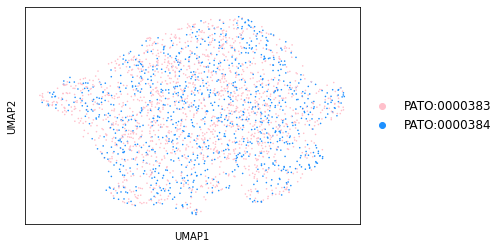

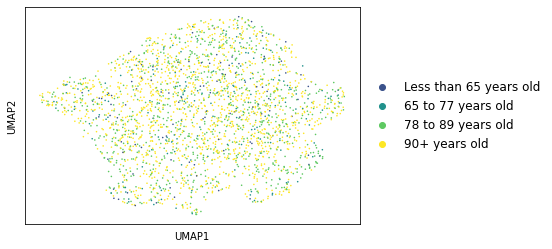

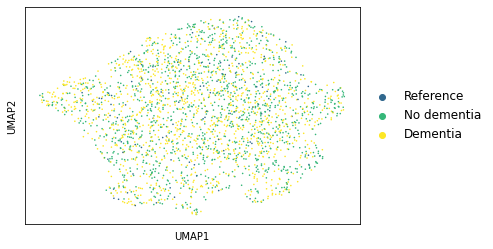

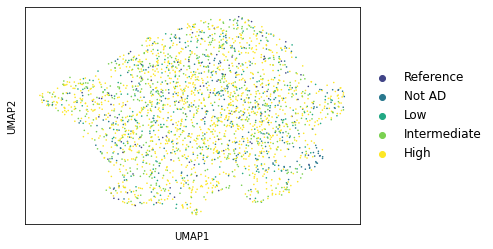

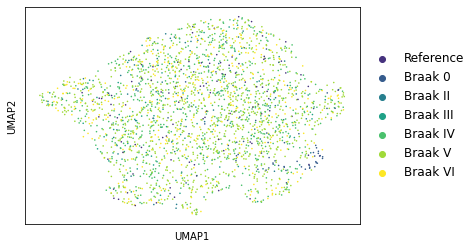

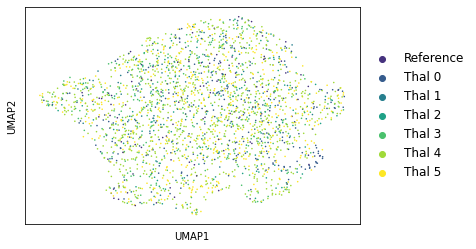

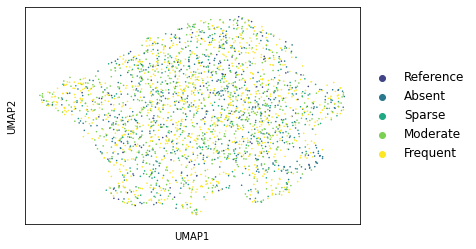

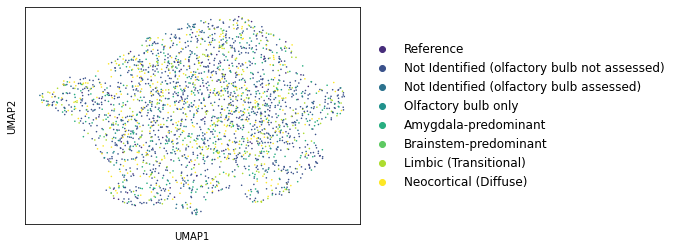

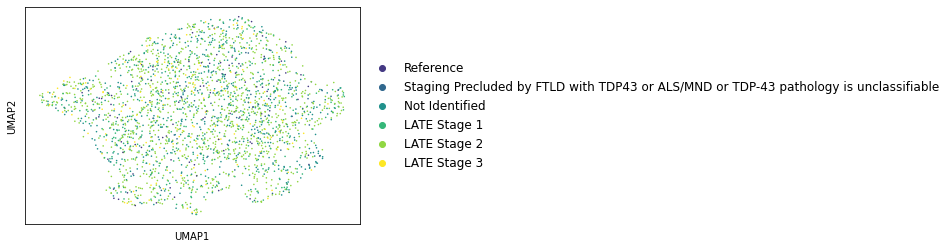

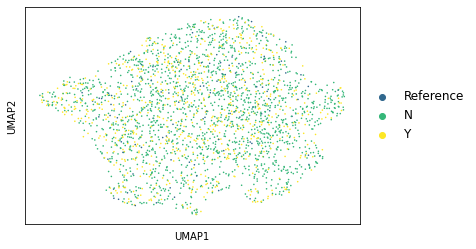

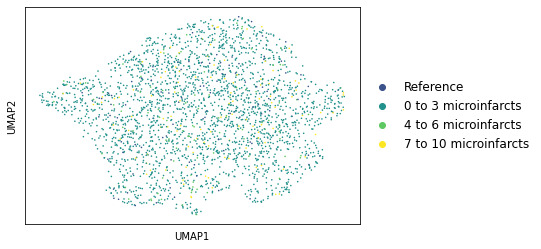

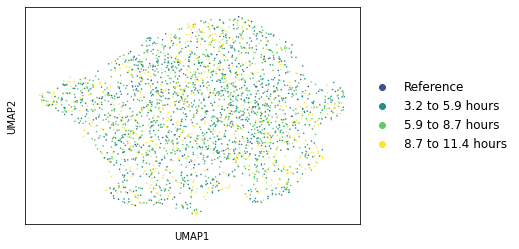

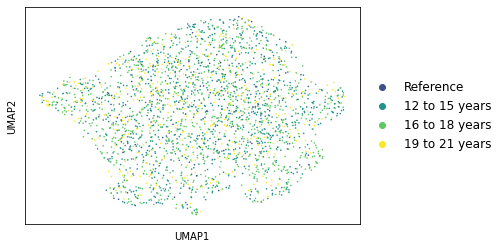

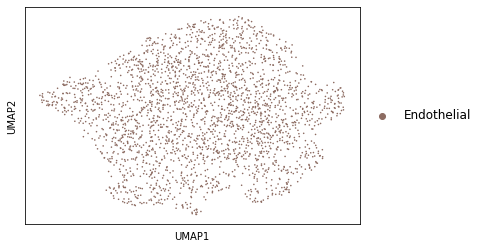

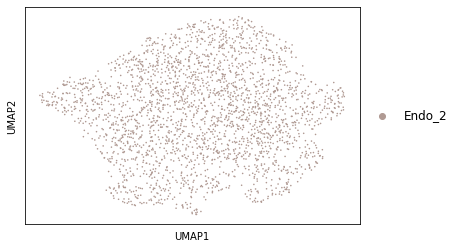

2023-07-14 09:11:15.321728 -- Skipping L2/3 IT because an output AnnData exists
2023-07-14 09:11:16.243926 -- Skipping L4 IT because an output AnnData exists
2023-07-14 09:11:16.337962 -- Skipping L5 ET because an output AnnData exists
2023-07-14 09:11:17.374088 -- Skipping L5 IT because an output AnnData exists
2023-07-14 09:11:17.662671 -- Skipping L5/6 NP because an output AnnData exists
2023-07-14 09:11:18.035623 -- Skipping L6 CT because an output AnnData exists
2023-07-14 09:11:18.585384 -- Skipping L6 IT because an output AnnData exists
2023-07-14 09:11:18.862532 -- Skipping L6 IT Car3 because an output AnnData exists
2023-07-14 09:11:19.116651 -- Skipping L6b because an output AnnData exists
2023-07-14 09:11:19.734226 -- Skipping Lamp5 because an output AnnData exists
2023-07-14 09:11:20.039509 -- Skipping Lamp5 Lhx6 because an output AnnData exists
2023-07-14 09:11:20.517074 -- Skipping Microglia-PVM because an output AnnData exists
2023-07-14 09:11:21.013250 -- Skipping OPC b

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [20]:
metadata_to_color = [
    "sex_ontology_term_id",
    "Age at death",
    "Cognitive status",
    "ADNC",
    "Braak stage",
    "Thal phase",
    "CERAD score",
    "Lewy body disease pathology",
    "LATE-NC stage",
    "APOE4 status",
    "Microinfarct pathology",
    "PMI",
    "Years of education"
]
split_key = "subclass_scANVI"

Parallel(n_jobs=1)(
    delayed(prepare_anndata)(
        adata=adata[(adata.obs[split_key] == i)],
        region=region,
        split_key=split_key,
        split_value=i,
        date_tag=date,
        metadata_to_color=metadata_to_color) for i in adata.obs[split_key].cat.categories
)

2023-07-14 09:15:42.663943 -- Starting export of Whole Taxonomy


... storing 'suspension_type' as categorical


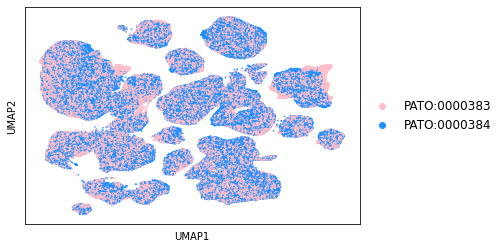

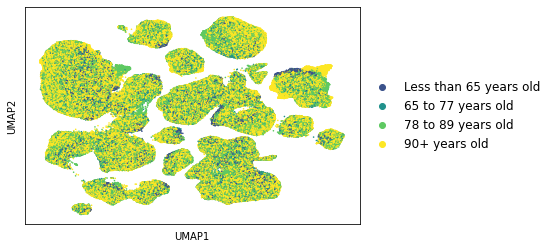

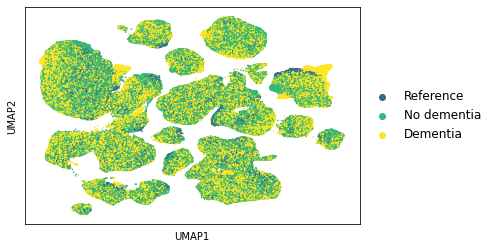

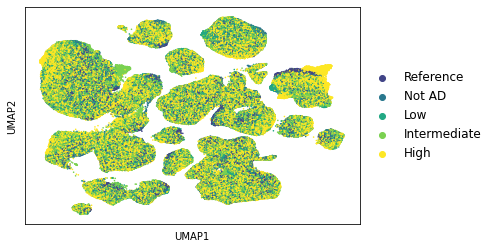

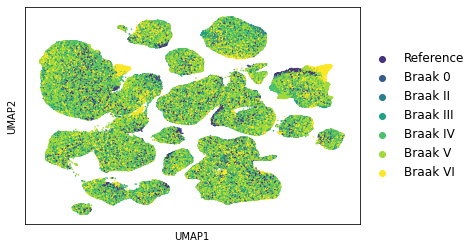

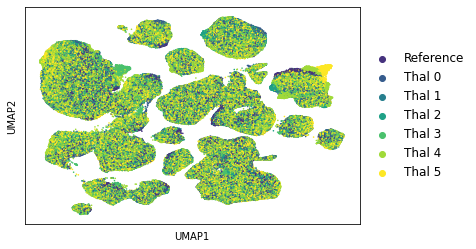

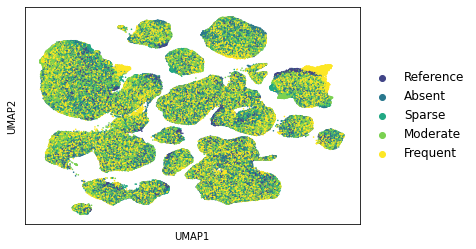

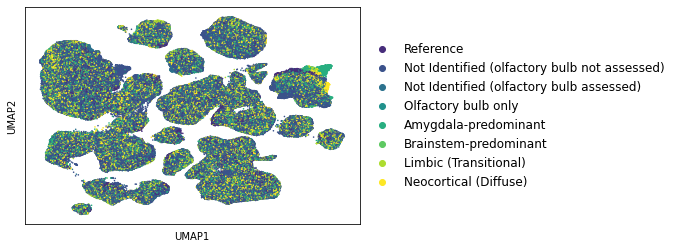

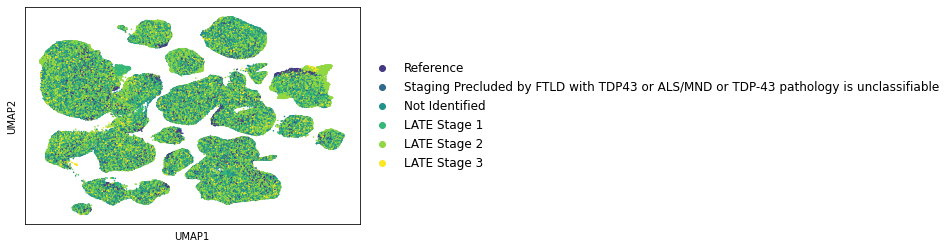

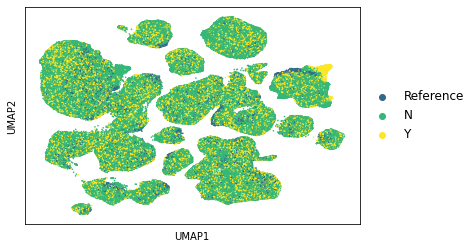

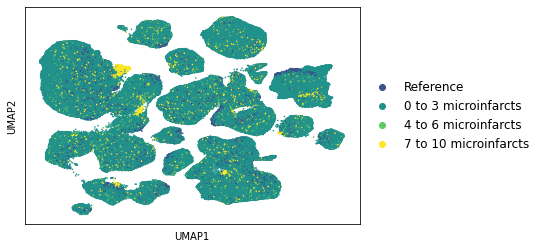

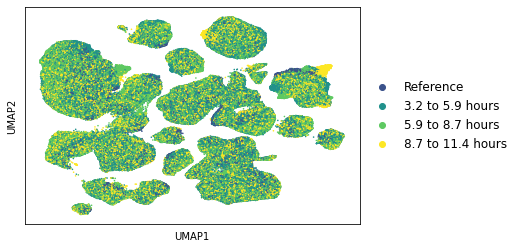

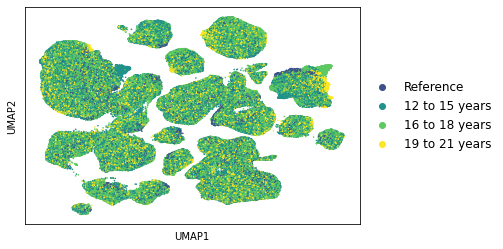

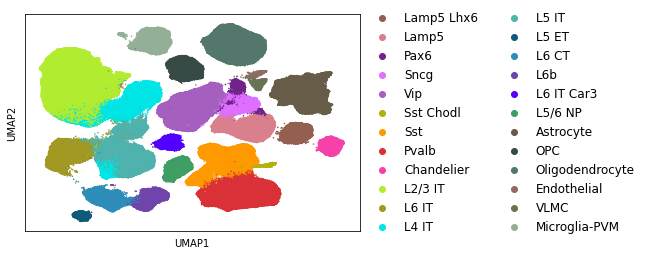

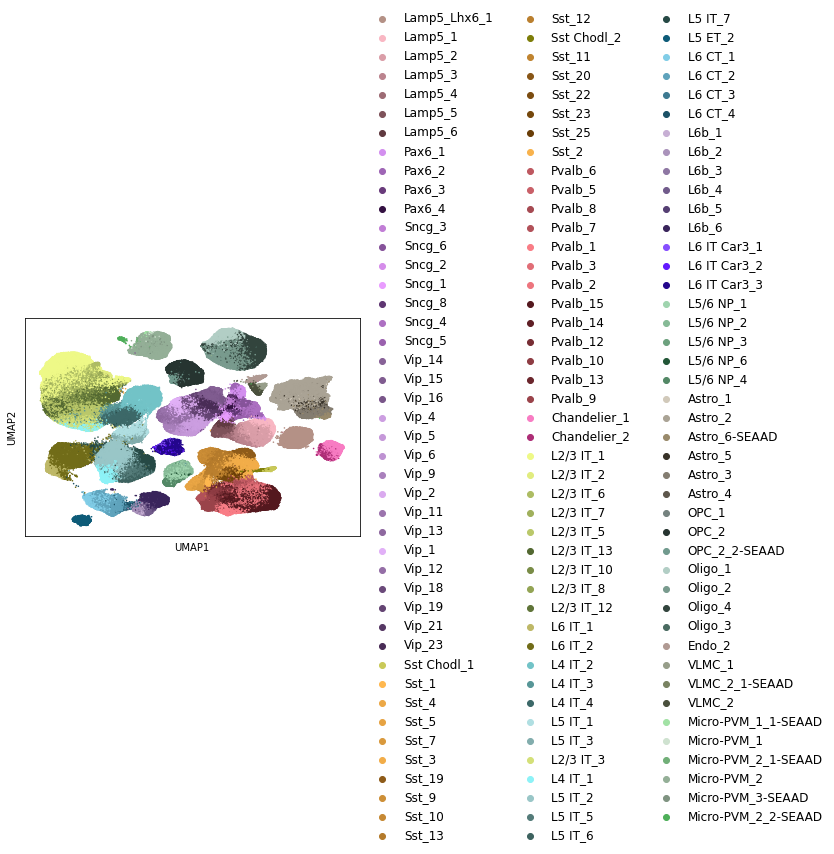

In [21]:
metadata_to_color = [
    "sex_ontology_term_id",
    "Age at death",
    "Cognitive status",
    "ADNC",
    "Braak stage",
    "Thal phase",
    "CERAD score",
    "Lewy body disease pathology",
    "LATE-NC stage",
    "APOE4 status",
    "Microinfarct pathology",
    "PMI",
    "Years of education"
]

prepare_anndata(
    adata=adata,
    region=region,
    split_key=None,
    split_value="Whole Taxonomy",
    date_tag="2023-07-12",
    metadata_to_color=metadata_to_color
)